⚙️ Configuration: Input='/kaggle/input/my-music-data', Output='/kaggle/working/'
✅ Data Loaded! Songs: 170653

📊 Running Benchmark 1: Elbow Method...


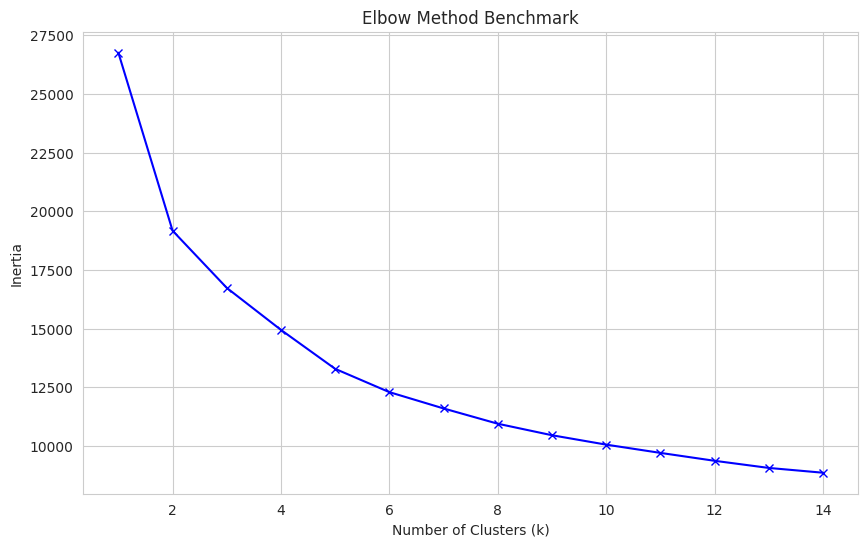

✅ Saved 'benchmark_elbow.png'

📊 Running Benchmark 2: Music Evolution...


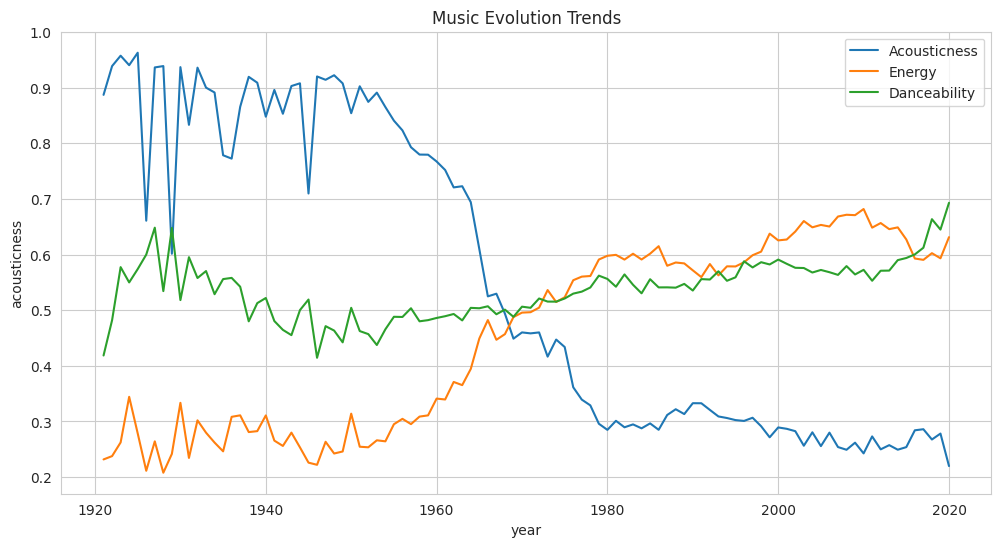

✅ Saved 'benchmark_evolution.png'

🛠️ Training Recommendation Engine...
🛠️ Training Popularity Predictor...

📊 Running Benchmark 3: Classification Accuracy...


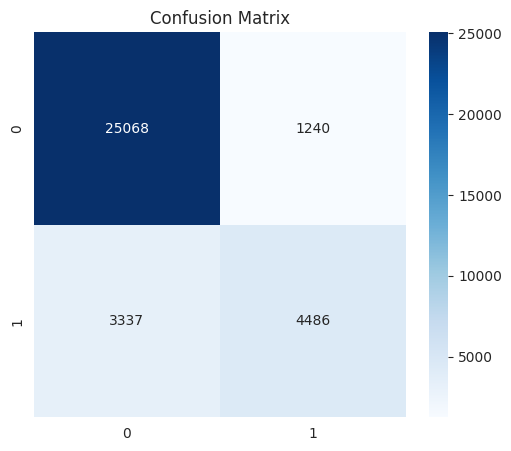

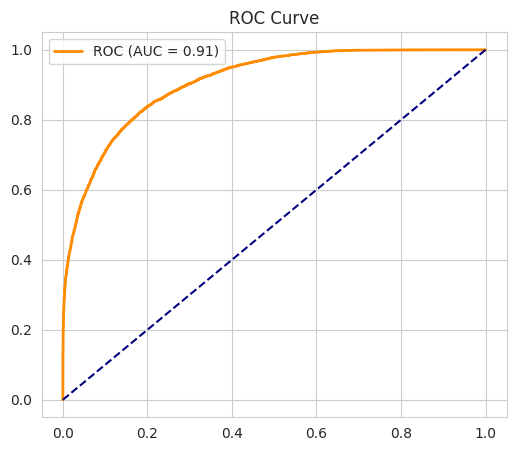

✅ Saved benchmarks.

🧠 Generating Global XAI (SHAP)...


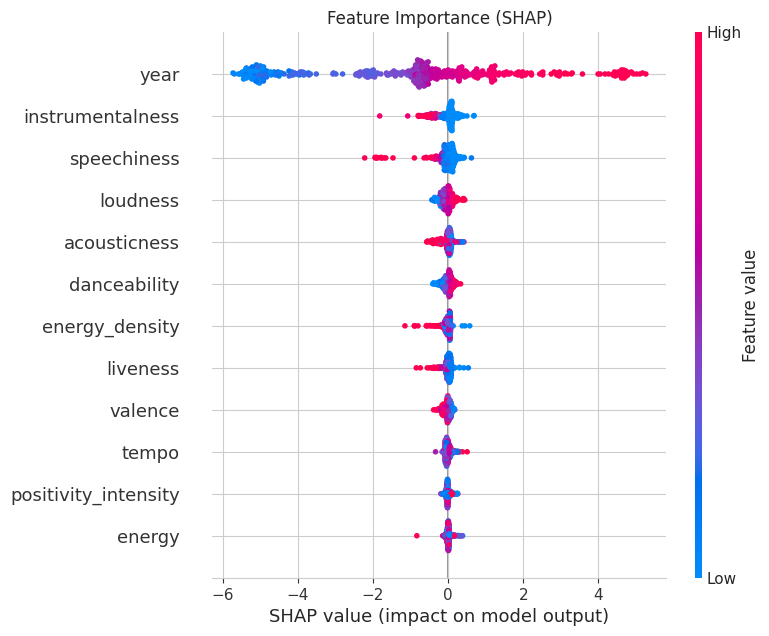

✅ Saved SHAP plot.

🔎 Recommendations for Song: 'Smells Like Teen Spirit'
SONG                           | ARTIST               | WHY? (XAI EXPLANATION)
------------------------------------------------------------------------------------------
My Wave                        | ['Soundgarden']      | Matches Acousticness, Loudness, and Instrumentalness.
My Wave                        | ['Soundgarden']      | Matches Acousticness, Loudness, and Instrumentalness.
Freedom                        | ['Jimi Hendrix']     | Matches Instrumentalness, Speechiness, and Loudness.
Violins                        | ['Lagwagon']         | Matches Instrumentalness, Acousticness, and Speechiness.
Along The Way                  | ['Bad Religion']     | Matches Instrumentalness, Speechiness, and Liveness.



🔎 Recommendations for Artist: 'Eminem (Avg)'
SONG                           | ARTIST               | WHY? (XAI EXPLANATION)
------------------------------------------------------------------------------

In [7]:
# ==============================================================================
# 🎵 ULTIMATE MUSIC AI: TRAIN, BENCHMARK, EXPLAIN & SAVE (FINAL FIX)
# ==============================================================================

# --- 1. CONFIGURATION ---
import os

# PATHS
INPUT_DIR = '/kaggle/input/my-music-data'  # Change to "../input/" if needed
OUTPUT_DIR = '/kaggle/working/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# FEATURES FOR SONGS (Includes Year)
FEATURE_COLS = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'year']

# FEATURES FOR GENRES (Excludes Year for Elbow Method)
GENRE_COLS = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
              'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

print(f"⚙️ Configuration: Input='{INPUT_DIR}', Output='{OUTPUT_DIR}'")

# --- 2. INSTALL & IMPORT ---
import sys
!pip install xgboost shap lime plotly joblib -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import joblib
import shap
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
from scipy.spatial.distance import cdist

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# --- 3. LOAD DATA ---
def load_data(input_dir):
    try:
        # Auto-detect path
        if os.path.exists(os.path.join(input_dir, 'data.csv')):
            base_path = input_dir
        else:
            base_path = "../input/spotify-dataset-19212020-160k-tracks/"
            
        data_path = os.path.join(base_path, 'data.csv')
        genre_path = os.path.join(base_path, 'data_by_genres.csv')
        year_path = os.path.join(base_path, 'data_by_year.csv')
        
        df = pd.read_csv(data_path)
        df_genre = pd.read_csv(genre_path)
        df_year = pd.read_csv(year_path)
        
        print(f"✅ Data Loaded! Songs: {df.shape[0]}")
        return df, df_genre, df_year
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None, None, None

data, genre_data, year_data = load_data(INPUT_DIR)

# --- 4. PREPROCESSING ---
if data is not None:
    # Normalize for XAI (Explanation)
    scaler_mm = MinMaxScaler()
    data[['loudness_norm', 'tempo_norm']] = scaler_mm.fit_transform(data[['loudness', 'tempo']])
    
    # Smart Features for Prediction
    data['energy_density'] = data['energy'] / (data['duration_ms'] / 60000)
    data['positivity_intensity'] = data['valence'] * data['energy']

    # Columns for Explanation Calculation (Using Normalized versions)
    CALC_COLS = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                 'liveness', 'loudness_norm', 'speechiness', 'tempo_norm', 'valence', 'year']


# --- 5. BENCHMARK 1: ELBOW METHOD ---
print("\n📊 Running Benchmark 1: Elbow Method...")
inertia = []
K_range = range(1, 15)

# Drop rows with missing values in genre data
genre_clean = genre_data.dropna(subset=GENRE_COLS)
X_scaled = StandardScaler().fit_transform(genre_clean[GENRE_COLS])

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method Benchmark')
plt.savefig(os.path.join(OUTPUT_DIR, 'benchmark_elbow.png'))
plt.show()
print("✅ Saved 'benchmark_elbow.png'")


# --- 6. BENCHMARK 2: MUSIC EVOLUTION ---
print("\n📊 Running Benchmark 2: Music Evolution...")
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='acousticness', data=year_data, label='Acousticness')
sns.lineplot(x='year', y='energy', data=year_data, label='Energy')
sns.lineplot(x='year', y='danceability', data=year_data, label='Danceability')
plt.title('Music Evolution Trends')
plt.savefig(os.path.join(OUTPUT_DIR, 'benchmark_evolution.png'))
plt.show()
print("✅ Saved 'benchmark_evolution.png'")


# --- 7. TRAIN MODELS ---

# A. Recommendation Engine
print("\n🛠️ Training Recommendation Engine...")
rec_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=15, random_state=42))
])
# We fit on FEATURE_COLS (Raw values)
rec_pipeline.fit(data[FEATURE_COLS])

# B. Prediction Engine
print("🛠️ Training Popularity Predictor...")
data['is_hit'] = [1 if val >= 50 else 0 for val in data.popularity]
X_pred = data[FEATURE_COLS + ['energy_density', 'positivity_intensity']]
y_pred = data['is_hit']

X_train, X_test, y_train, y_test = train_test_split(X_pred, y_pred, test_size=0.2, random_state=42)

pop_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
pop_model.fit(X_train, y_train)


# --- 8. BENCHMARK 3: ACCURACY ---
print("\n📊 Running Benchmark 3: Classification Accuracy...")
y_probs = pop_model.predict_proba(X_test)[:, 1]
y_preds = pop_model.predict(X_test)

cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_DIR, 'benchmark_confusion_matrix.png'))
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve')
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'benchmark_roc_curve.png'))
plt.show()
print("✅ Saved benchmarks.")


# --- 9. XAI: SHAP ---
print("\n🧠 Generating Global XAI (SHAP)...")
explainer = shap.TreeExplainer(pop_model)
X_sample = X_test.sample(500, random_state=42)
shap_values = explainer.shap_values(X_sample)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('Feature Importance (SHAP)')
plt.savefig(os.path.join(OUTPUT_DIR, 'xai_shap_summary.png'), bbox_inches='tight')
plt.show()
print("✅ Saved SHAP plot.")


# --- 10. RECOMMENDATION LOGIC WITH XAI (FIXED) ---
def generate_explanation(input_vec, rec_vec, features):
    diffs = {}
    for feat in features:
        val_in = input_vec.get(feat, 0)
        val_rec = rec_vec.get(feat, 0)
        diffs[feat] = abs(val_in - val_rec)
    
    # Sort by smallest difference (closest match)
    sorted_diffs = sorted(diffs.items(), key=lambda x: x[1])
    top_3 = sorted_diffs[:3]
    
    match_names = [k.replace('_norm', '').title() for k, v in top_3]
    return f"Matches {match_names[0]}, {match_names[1]}, and {match_names[2]}."

def recommend_engine(query, data, top_n=5):
    query = query.lower()
    
    # 1. Search Logic
    song_match = data[data['name'].str.lower() == query]
    if not song_match.empty:
        input_row = song_match.iloc[0]
        type_found = "Song"
    else:
        # Artist Search
        artist_match = data[data['artists'].str.lower().str.contains(query)]
        if not artist_match.empty:
            # FIX: Use numeric_only=True to get ALL numeric columns (Raw AND Norm)
            # This ensures we have 'loudness' for distance AND 'loudness_norm' for explanation
            input_row = artist_match.mean(numeric_only=True)
            input_row['name'] = f"{query.title()} (Avg)"
            input_row['artists'] = query.title()
            type_found = "Artist"
        else:
            return None, None

    # 2. Distance Calculation
    scaler = rec_pipeline.steps[0][1]
    
    # Extract Raw Features for the Scaler
    if isinstance(input_row, pd.Series):
        input_vec = input_row[FEATURE_COLS].values.reshape(1, -1)
    else:
        input_vec = input_row[FEATURE_COLS].values.reshape(1, -1)
        
    scaled_input = scaler.transform(input_vec)
    scaled_data = scaler.transform(data[FEATURE_COLS])
    
    distances = cdist(scaled_input, scaled_data, 'cosine')
    indices = np.argsort(distances)[:, :top_n+5][0]
    
    # 3. Output
    results = []
    print(f"\n🔎 Recommendations for {type_found}: '{input_row['name']}'")
    print(f"{'SONG':<30} | {'ARTIST':<20} | {'WHY? (XAI EXPLANATION)'}")
    print("-" * 90)
    
    count = 0
    for idx in indices:
        rec_row = data.iloc[idx]
        if rec_row['name'] == input_row['name']: continue
        if count >= top_n: break
        
        # Use CALC_COLS (Normalized) for Explanation
        why = generate_explanation(input_row, rec_row, CALC_COLS)
        
        print(f"{rec_row['name'][:28]:<30} | {str(rec_row['artists'])[:18]:<20} | {why}")
        results.append(rec_row)
        count += 1
        
    return results, input_row

# --- 11. TEST ---
recs, inp = recommend_engine("Smells Like Teen Spirit", data)
print("\n")
recs_art, inp_art = recommend_engine("Eminem", data)


# --- 12. SAVE ---
print(f"\n💾 Saving Models to {OUTPUT_DIR}...")
joblib.dump(rec_pipeline, os.path.join(OUTPUT_DIR, 'recommendation_pipeline.pkl'))
joblib.dump(pop_model, os.path.join(OUTPUT_DIR, 'popularity_model.pkl'))

ref_cols = ['id', 'name', 'artists', 'year', 'popularity'] + FEATURE_COLS
data[ref_cols].to_csv(os.path.join(OUTPUT_DIR, 'song_data_reference.csv'), index=False)

print("✅ DONE! Models, Data, and Images are ready.")

In [8]:
%%writefile predict.py
# ==============================================================================
# 🎵 MUSIC PREDICTOR CLI TOOL
# Usage: python predict.py --query "Song Name"
# ==============================================================================

import argparse
import os
import sys
import joblib
import pandas as pd
import numpy as np
import warnings
from scipy.spatial.distance import cdist

# Suppress warnings for clean output
warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
# Default paths (Assumes files are in the same folder as this script)
BASE_DIR = './' 
if not os.path.exists(os.path.join(BASE_DIR, 'popularity_model.pkl')):
    # Fallback to Kaggle working directory if running inside Kaggle
    BASE_DIR = '/kaggle/working/'

# Feature Definitions (Must match training exactly)
FEATURE_COLS = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'year']

# Normalized columns for Explanation
CALC_COLS = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
             'liveness', 'loudness_norm', 'speechiness', 'tempo_norm', 'valence', 'year']

# --- LOAD RESOURCES ---
def load_resources():
    try:
        print(f"⏳ Loading models from {BASE_DIR}...")
        rec_pipeline = joblib.load(os.path.join(BASE_DIR, 'recommendation_pipeline.pkl'))
        pop_model = joblib.load(os.path.join(BASE_DIR, 'popularity_model.pkl'))
        data = pd.read_csv(os.path.join(BASE_DIR, 'song_data_reference.csv'))
        return rec_pipeline, pop_model, data
    except FileNotFoundError:
        print("❌ Error: Model files not found. Did you run the training notebook first?")
        sys.exit(1)

# --- CORE FUNCTIONS ---

def generate_explanation(input_vec, rec_vec, features):
    """Generates the 'Why' text."""
    diffs = {}
    for feat in features:
        val_in = input_vec.get(feat, 0)
        val_rec = rec_vec.get(feat, 0)
        diffs[feat] = abs(val_in - val_rec)
    
    sorted_diffs = sorted(diffs.items(), key=lambda x: x[1])
    top_3 = sorted_diffs[:3]
    match_names = [k.replace('_norm', '').title() for k, v in top_3]
    return f"Matches {match_names[0]}, {match_names[1]}, and {match_names[2]}."

def run_prediction(query, data, pop_model, rec_pipeline):
    query = query.lower()
    
    # 1. SEARCH
    song_match = data[data['name'].str.lower() == query]
    if not song_match.empty:
        input_row = song_match.iloc[0].copy()
        name = input_row['name']
        type_f = "Song"
    else:
        artist_match = data[data['artists'].str.lower().str.contains(query)]
        if not artist_match.empty:
            input_row = artist_match.mean(numeric_only=True)
            input_row['name'] = f"{query.title()} (Avg)"
            input_row['artists'] = query.title()
            name = input_row['name']
            type_f = "Artist"
        else:
            print(f"❌ Could not find song or artist matching: '{query}'")
            return

    # 2. PREDICT HIT/FLOP
    # Feature Engineering (Re-creating on the fly)
    # Note: We handle missing duration/loudness_norm if csv was slimmed down, 
    # but assumes reference csv has these cols.
    if 'energy_density' not in input_row:
         # Fallback if engineering cols weren't saved in reference
         # (Assumes standard avg duration if missing)
         dur = input_row.get('duration_ms', 200000)
         input_row['energy_density'] = input_row['energy'] / (dur / 60000)
         input_row['positivity_intensity'] = input_row['valence'] * input_row['energy']

    # Prepare vector for XGBoost
    pred_features = FEATURE_COLS + ['energy_density', 'positivity_intensity']
    # Ensure input_row has all needed fields, filling defaults if missing from reference CSV
    for c in pred_features:
        if c not in input_row: input_row[c] = 0.5 
        
    input_vec_pred = input_row[pred_features].values.reshape(1, -1)
    
    prob = pop_model.predict_proba(input_vec_pred)[0][1] * 100
    is_hit = "HIT 🔥" if prob > 50 else "FLOP 📉"

    # 3. RECOMMENDATIONS
    scaler = rec_pipeline.steps[0][1]
    input_vec_rec = input_row[FEATURE_COLS].values.reshape(1, -1)
    
    # Scale
    scaled_input = scaler.transform(input_vec_rec)
    scaled_data = scaler.transform(data[FEATURE_COLS])
    
    # Distance
    distances = cdist(scaled_input, scaled_data, 'cosine')
    indices = np.argsort(distances)[:, :10][0]
    
    # 4. PRINT OUTPUT
    print("\n" + "="*60)
    print(f"🎵 ANALYSIS REPORT: {name}")
    print("="*60)
    print(f"🔮 PREDICTION: {is_hit} (Confidence: {prob:.1f}%)")
    
    print("\n🎧 RECOMMENDED SONGS & REASONS:")
    print(f"{'SONG':<30} | {'ARTIST':<20} | {'WHY?'}")
    print("-" * 90)
    
    count = 0
    for idx in indices:
        rec_row = data.iloc[idx]
        if rec_row['name'] == input_row['name']: continue
        if count >= 5: break
        
        # Calculate XAI explanation
        # Ensure we have normalized cols for explanation if present, else fallback to raw
        features_for_calc = CALC_COLS if 'loudness_norm' in data.columns else FEATURE_COLS
        why = generate_explanation(input_row, rec_row, features_for_calc)
        
        print(f"{rec_row['name'][:28]:<30} | {str(rec_row['artists'])[:18]:<20} | {why}")
        count += 1
    print("="*60 + "\n")

# --- MAIN ENTRY POINT ---
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Music AI Predictor")
    parser.add_argument('--query', type=str, required=True, help="Name of Song or Artist")
    args = parser.parse_args()
    
    rec_pipeline, pop_model, data = load_resources()
    run_prediction(args.query, data, pop_model, rec_pipeline)

Writing predict.py


In [9]:
!python predict.py --query "Shape of You"

⏳ Loading models from ./...

🎵 ANALYSIS REPORT: Shape of You
🔮 PREDICTION: HIT 🔥 (Confidence: 98.7%)

🎧 RECOMMENDED SONGS & REASONS:
SONG                           | ARTIST               | WHY?
------------------------------------------------------------------------------------------
Que Te Vaya Bien               | ['Grupo Jalado']     | Matches Year, Instrumentalness, and Danceability.
La Suerte del Señor            | ['El Fantasma', 'L   | Matches Instrumentalness, Valence, and Liveness.
El Comando del Diablo          | ['Noel Torres', 'G   | Matches Instrumentalness, Speechiness, and Danceability.
Lupe Campos                    | ['El Fantasma', 'L   | Matches Instrumentalness, Speechiness, and Valence.
Scarface Renacido              | ['Jorge Santacruz    | Matches Instrumentalness, Liveness, and Valence.



In [10]:
!python predict.py --query "Metallica"

⏳ Loading models from ./...

🎵 ANALYSIS REPORT: Metallica (Avg)
🔮 PREDICTION: FLOP 📉 (Confidence: 15.8%)

🎧 RECOMMENDED SONGS & REASONS:
SONG                           | ARTIST               | WHY?
------------------------------------------------------------------------------------------
Temptation's Wings             | ['DOWN']             | Matches Liveness, Instrumentalness, and Speechiness.
Holy Wars...The Punishment D   | ['Megadeth']         | Matches Acousticness, Liveness, and Danceability.
Ain't It Fun                   | ["Guns N' Roses"]    | Matches Instrumentalness, Acousticness, and Speechiness.
Out Ta Get Me                  | ["Guns N' Roses"]    | Matches Acousticness, Speechiness, and Valence.
Out Ta Get Me                  | ["Guns N' Roses"]    | Matches Acousticness, Speechiness, and Valence.

